In [1]:
import os
os.chdir('../')

## Imports

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score

from src.develop.feature_importance import ShapValues
from src.develop.cross_validation import CrossValidation

from src.train import ClassificationModel, TwoStepCalibration


# warnings
import warnings
warnings.filterwarnings('ignore')

## Data Collect

In [3]:
df_model = pd.read_csv("notebooks/outputs/df_model.csv")

df_model = df_model[(df_model.dt_calendar >= "2020-01")]
df_model["dt_calendar"] = pd.to_datetime(df_model["dt_calendar"])

print(df_model.shape)
df_model.head()

(6848, 21)


,dt_calendar,id_imobiliaria,lat_imob,long_imob,is_active,is_activated,is_commun_first_90days,is_debelado,is_debelado_first_4months,is_indemnified,...,is_indemn_first_6months,vl_locacao,is_churn,exonerated_first_6months,rating_A,rating_B,rating_C,rating_D,rating_E,target
459,2020-01-01,38,-20.31,-40.30,112.0,7.0,0.0,3,0.0,1,...,0,1091.59,2.0,0,0.00,0.00,0.14,0.00,0.29,0.0
460,2020-01-01,81,-27.60,-48.61,173.0,13.0,0.0,3,0.0,6,...,0,1404.38,2.0,0,0.08,0.15,0.23,0.08,0.00,0.0
461,2020-01-01,128,-29.92,-51.18,498.0,14.0,0.0,6,0.0,0,...,0,1049.74,2.0,0,0.14,0.07,0.07,0.21,0.07,0.0
462,2020-01-01,215,-31.77,-52.34,616.0,33.0,0.0,20,0.0,5,...,0,934.64,0.0,0,0.09,0.03,0.18,0.00,0.09,0.0
463,2020-01-01,222,-29.17,-51.17,302.0,24.0,0.0,5,0.0,2,...,0,974.37,1.0,0,0.12,0.17,0.17,0.04,0.08,0.0


## Modelo

### Instâncias

In [ ]:
path = "notebooks/outputs/params.json"

In [4]:
with open(path, "r") as f:
    params_et = json.load(f)
    
params_lgbm =  {
    'metric': 'auc',
    'random_state': 5,
    'objective': 'binary',
    'max_depth': 3,
    'n_estimators': 500,
    'subsample': 0.4,
    'colsample_bytree': 0.5,
    'learning_rate': 0.01
}
parameters_lr = {
    'solver':'sag',
    'C': 1e6,
    'fit_intercept': True
}

In [6]:
lgbm = LGBMClassifier(**params_lgbm)
et = ExtraTreesClassifier(
    random_state=5, oob_score=True, bootstrap=True,
    **params_et
)
lr = LogisticRegression(**parameters_lr)

et_lr = TwoStepCalibration(et, lr)
lgbm_lr = TwoStepCalibration(lgbm, lr)

### Cross-Validation

In [7]:
et_cv = CrossValidation(df_model, et, roc_auc_score)
lgbm_cv = CrossValidation(df_model, lgbm, roc_auc_score)

In [8]:
et_cv.fit(from_="2022-06", to_="2022-11")

TRAINING UNTIL (2022-05) | VALIDATING FROM (2022-06) UNTIL (2022-11): (AUC=0.7587)
TRAINING UNTIL (2022-06) | VALIDATING FROM (2022-07) UNTIL (2022-11): (AUC=0.7628)
TRAINING UNTIL (2022-07) | VALIDATING FROM (2022-08) UNTIL (2022-11): (AUC=0.7323)
TRAINING UNTIL (2022-08) | VALIDATING FROM (2022-09) UNTIL (2022-11): (AUC=0.7435)
TRAINING UNTIL (2022-09) | VALIDATING FROM (2022-10) UNTIL (2022-11): (AUC=0.7162)
TRAINING UNTIL (2022-10) | VALIDATING FROM (2022-11) UNTIL (2022-11): (AUC=0.7018)


0.7359

In [9]:
lgbm_cv.fit(from_="2022-06", to_="2022-11")

TRAINING UNTIL (2022-05) | VALIDATING FROM (2022-06) UNTIL (2022-11): (AUC=0.7501)
TRAINING UNTIL (2022-06) | VALIDATING FROM (2022-07) UNTIL (2022-11): (AUC=0.7544)
TRAINING UNTIL (2022-07) | VALIDATING FROM (2022-08) UNTIL (2022-11): (AUC=0.7237)
TRAINING UNTIL (2022-08) | VALIDATING FROM (2022-09) UNTIL (2022-11): (AUC=0.7399)
TRAINING UNTIL (2022-09) | VALIDATING FROM (2022-10) UNTIL (2022-11): (AUC=0.7158)
TRAINING UNTIL (2022-10) | VALIDATING FROM (2022-11) UNTIL (2022-11): (AUC=0.7467)


0.7384

### Treino e Teste

Jogar os predicts na calculadora

In [9]:
et_model = ClassificationModel(df_model, et_lr, roc_auc_score)
lgbm_model = ClassificationModel(df_model, lgbm_lr, roc_auc_score)

In [10]:
et_model.fit(cutoff_period="2022-12")
et_model.test_model(cutoff_period="2022-12")

TESTING ON (2022-12)


0.7161

In [12]:
lgbm_model.fit(cutoff_period="2022-12")
lgbm_model.test_model(cutoff_period="2022-12")

TESTING ON (2022-12)


0.6522

## Calibrated Bins

Ver referencia de volumetria do modelo do matheus

In [13]:
y_pred_et = et_lr.predict_proba(et_model.X_test)[:,1]
y_pred_lgbm = lgbm_lr.predict_proba(lgbm_model.X_test)[:,1]

In [14]:
print(f"""
[Extra-Tree]
y_pred: {round(y_pred_et.sum(), 2)}
y_test: {et_model.y_test.sum()}

[LGBM]
y_pred: {round(y_pred_lgbm.sum(), 2)}
y_test: {lgbm_model.y_test.sum()}
""")


[Extra-Tree]
y_pred: 14.89
y_test: 4.0

[LGBM]
y_pred: 15.16
y_test: 4.0



In [17]:
label_segment = lambda x: pd.cut(
        x, 
        bins=[0, 0.02, 0.023, 0.028, 0.038, 1], 
        labels=['A', 'B', 'C', 'D', 'E']
    )

metrics = {
    'predictions': y_pred_et,
    'deciles': pd.qcut(y_pred_et, 10, labels=False),
    'segments': label_segment(y_pred_et),
    'target': y_pred_et 
}

segmentation_df = pd.DataFrame(metrics)

decile_rates = segmentation_df.groupby('deciles')['target'].mean()
segment_rates = segmentation_df.groupby('segments')['target'].agg(['mean', 'size'])


In [18]:
decile_rates

deciles
0    0.019369
1    0.020391
2    0.021427
3    0.022826
4    0.025101
5    0.028212
6    0.032220
7    0.038320
8    0.048408
9    0.119677
Name: target, dtype: float64

In [26]:
segmentation_df

,predictions,deciles,segments,target
0,0.047603,8,E,0.047603
1,0.021637,2,B,0.021637
2,0.019385,0,A,0.019385
3,0.021082,2,B,0.021082
4,0.068578,9,E,0.068578
...,...,...,...,...
390,0.021632,2,B,0.021632
391,0.020264,1,B,0.020264
392,0.025722,4,C,0.025722
393,0.022306,3,B,0.022306


In [19]:
segment_rates

,mean,size
segments,,
A,0.019335,38
B,0.021275,106
C,0.025201,69
D,0.032328,84
E,0.075936,98


## Predicted DataFrame

In [53]:
df_ = df_model[df_model.dt_calendar == "2022-12"][["id_imobiliaria"]].reset_index(drop=True)

In [54]:
df_preds = df_.merge(segmentation_df)
df_preds

,id_imobiliaria,predictions,deciles,segments,target
0,38,0.047603,8,E,0.047603
1,50,0.021637,2,B,0.021637
2,52,0.019385,0,A,0.019385
3,63,0.021082,2,B,0.021082
4,81,0.068578,9,E,0.068578
...,...,...,...,...,...
390,16567,0.021632,2,B,0.021632
391,17545,0.020264,1,B,0.020264
392,18909,0.025722,4,C,0.025722
393,25860,0.022306,3,B,0.022306


## Feature Importance

In [20]:
X_train, y_train = et_model.X_train, et_model.y_train

In [21]:
shap_et = ShapValues(et, X_train)
shap_lgbm = ShapValues(lgbm, X_train)

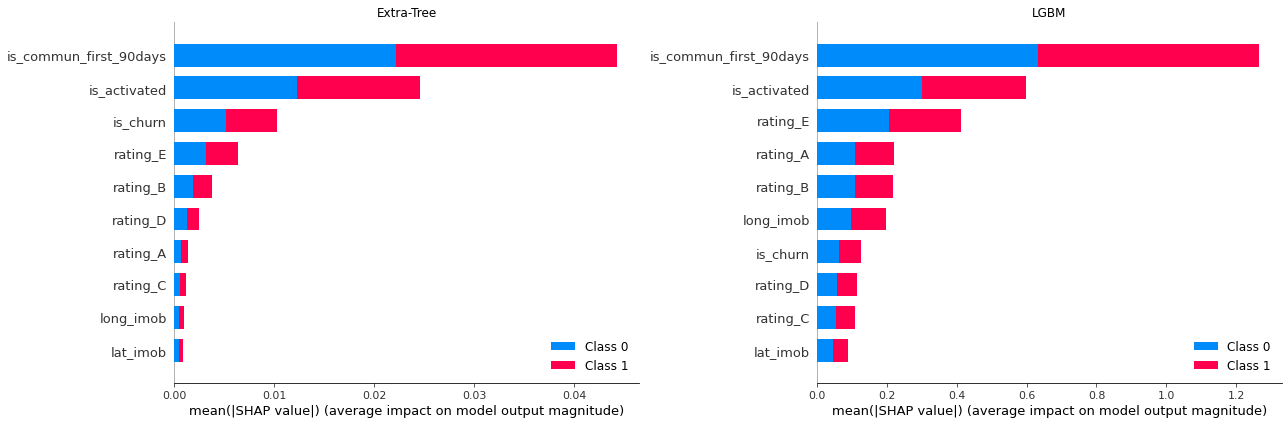

In [22]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
shap_et.summary_plot(plot_type="bar", plot_size=None, show=False)
plt.title("Extra-Tree")

plt.subplot(1,2,2)
shap_lgbm.summary_plot(plot_type="bar", plot_size=None, show=False)
plt.title("LGBM")
plt.tight_layout()
plt.show()

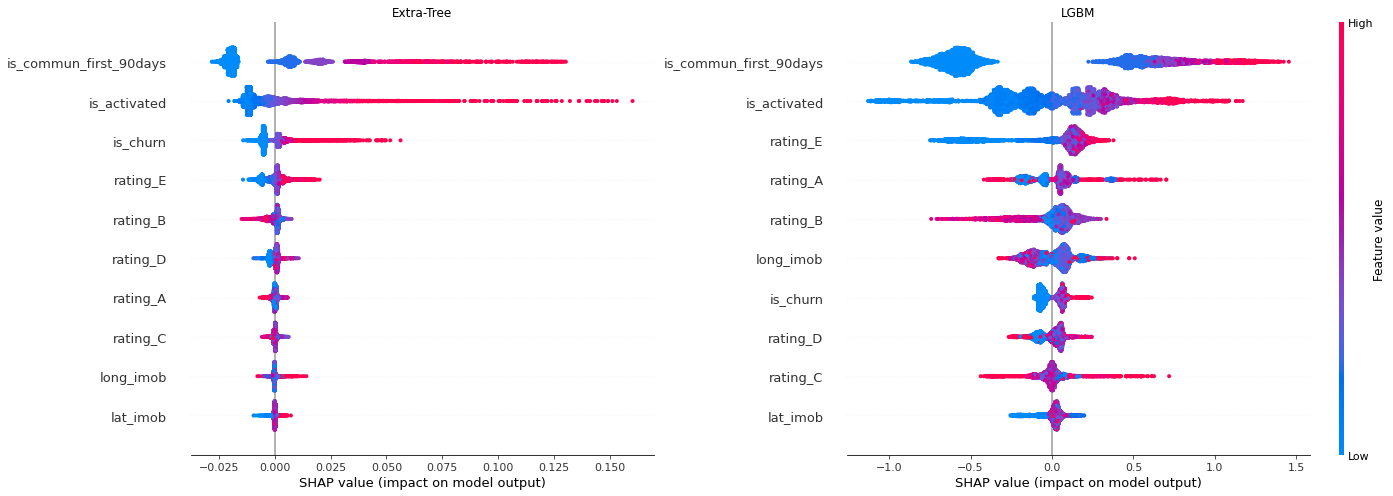

In [23]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
shap_et.summary_plot(plot_size=None, show=False)
plt.title("Extra-Tree")

plt.subplot(1,2,2)
shap_lgbm.summary_plot(plot_size=None, show=False)
plt.title("LGBM")
plt.tight_layout()
plt.show()

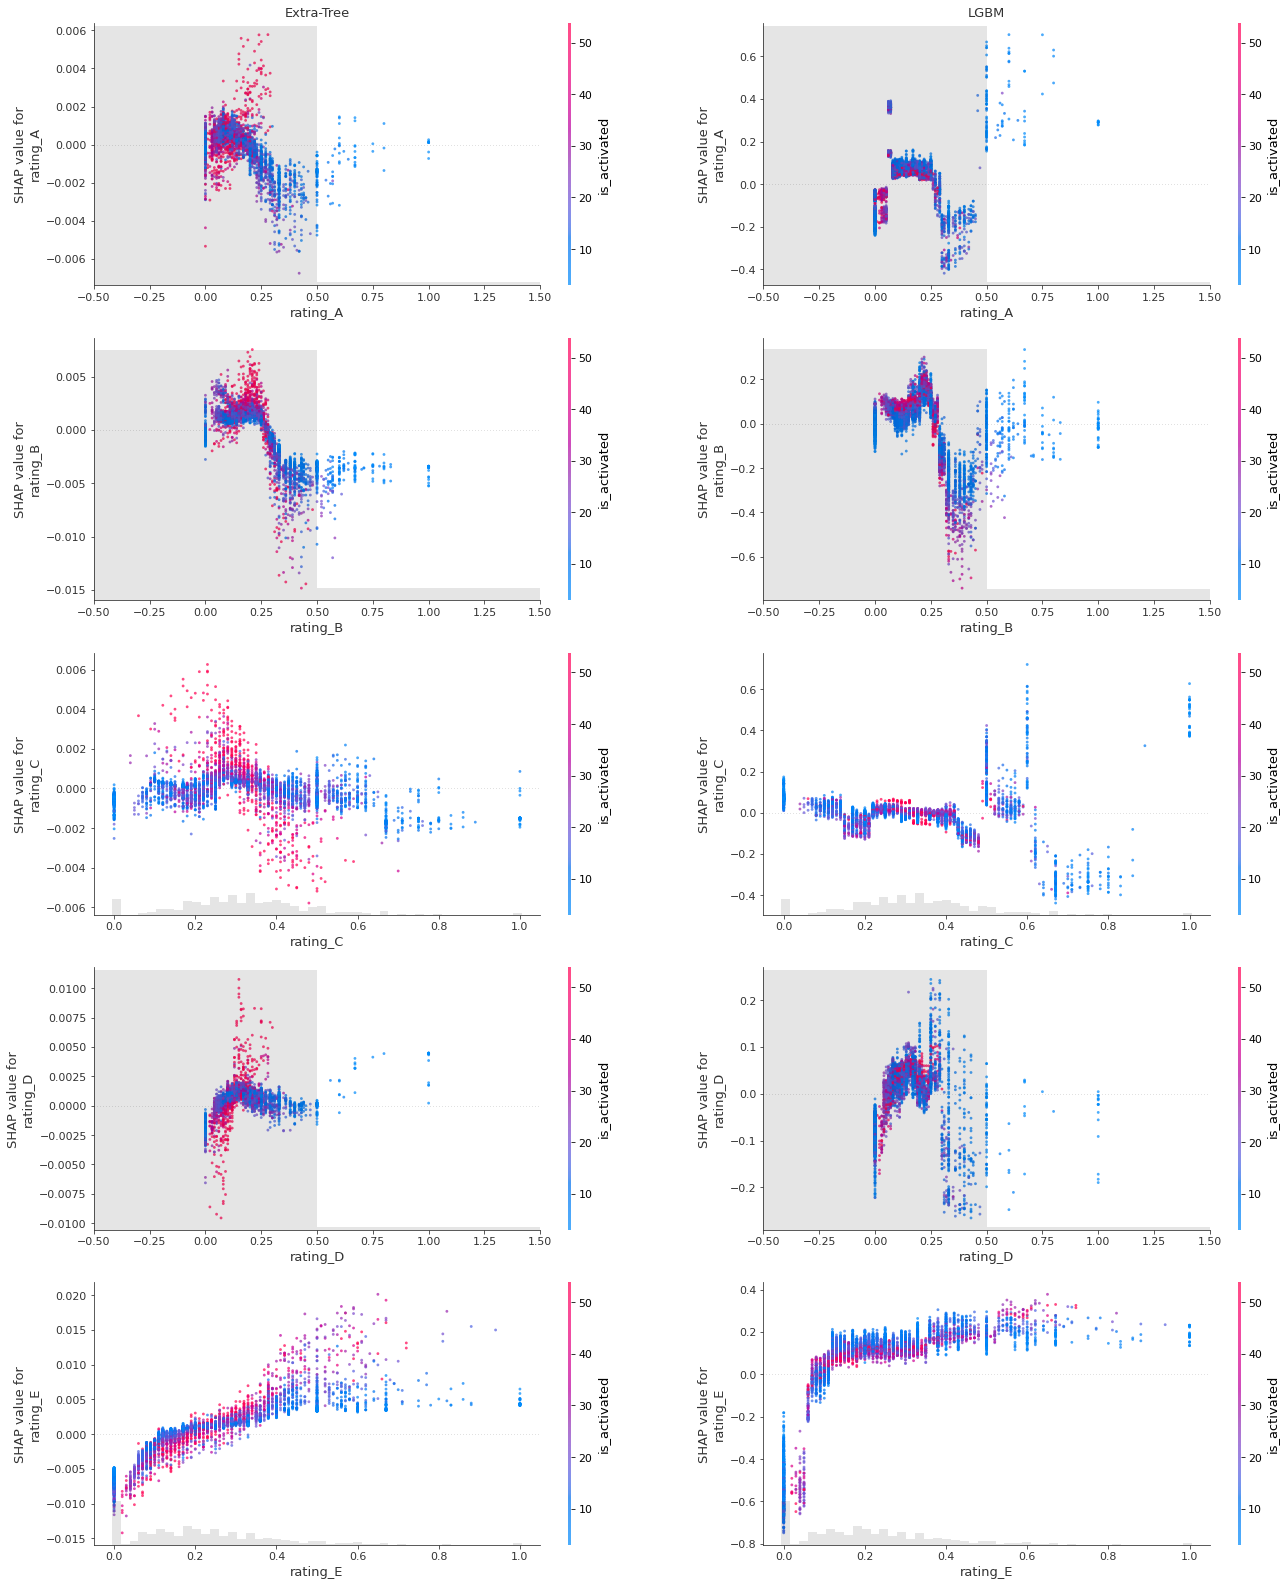

In [24]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(22,28))
shap_et.scatter_plot(["rating_A", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[0, 0], title="Extra-Tree", show=False)
shap_et.scatter_plot(["rating_B", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[1, 0], show=False)
shap_et.scatter_plot(["rating_C", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[2, 0], show=False)
shap_et.scatter_plot(["rating_D", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[3, 0], show=False)
shap_et.scatter_plot(["rating_E", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[4, 0], show=False)

shap_lgbm.scatter_plot(["rating_A", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[0, 1], title="LGBM", show=False)
shap_lgbm.scatter_plot(["rating_B", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[1, 1], show=False)
shap_lgbm.scatter_plot(["rating_C", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[2, 1], show=False)
shap_lgbm.scatter_plot(["rating_D", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[3, 1], show=False)
shap_lgbm.scatter_plot(["rating_E", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[4, 1], show=False)

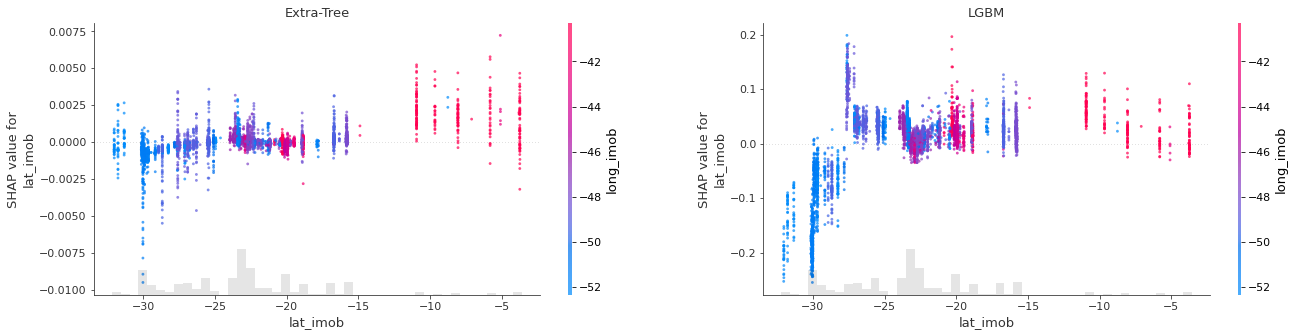

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,5))
shap_et.scatter_plot(["lat_imob", "long_imob"], dependence=True, dot_size=8, alpha=0.7, ax=axes[0], title="Extra-Tree", show=False)
shap_lgbm.scatter_plot(["lat_imob", "long_imob"], dependence=True, dot_size=8, alpha=0.7, ax=axes[1], title="LGBM", show=False)